# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

In [64]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)
agg_result_file='./data/uv_melt/uvmelt_agg_230901.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv', index_col=0)

ecl_oligo_df = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv', index_col=0)

<Axes: xlabel='dH', ylabel='Density'>

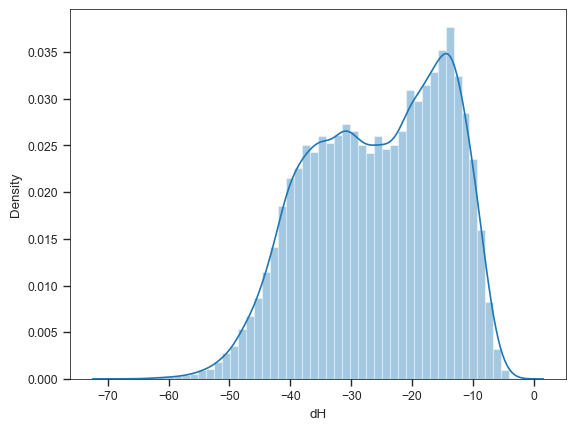

In [74]:
sns.distplot(arr.dH)

In [76]:
np.exp(4)

54.598150033144236

## 1-step linear regression

Trying to minimize manual model engineering...

### Train

In [65]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False, directly_fit_3_4_hairpin_loop=False)
print(feats.shape)

(27732, 178)
CPU times: user 12.8 s, sys: 94 ms, total: 12.9 s
Wall time: 12.9 s


In [66]:
""" Fixed parameters during training """
param_set_template_file = './models/dna04.json'
fixed_pclass = ['hairpin_size', 'interior_size', 'bulge_size', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_mismatch', 'stack']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_template_file, fixed_pclass=fixed_pclass)
print(len(fixed_feature_names))

fixed_feature_names = [x for x in fixed_feature_names if x in feats.columns]
print('#fixed features =', len(fixed_feature_names))

352
#fixed features = 26


Fitting dH
Regularization strength is 0.010000
Fitting dG
Regularization strength is 0.010000
CPU times: user 5min 40s, sys: 7min 40s, total: 13min 21s
Wall time: 2min


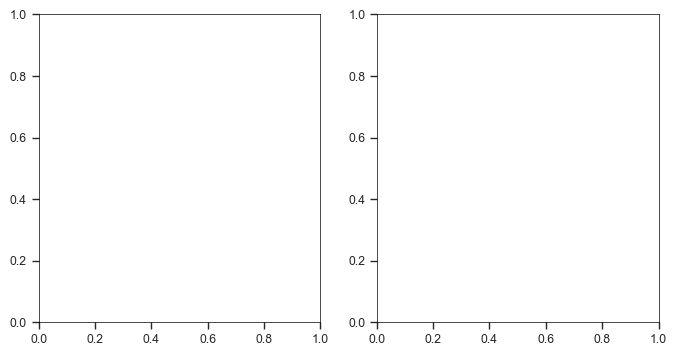

In [70]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()
param_name_dict = dict(dH='dH', dG='dG_37')
for i,param in enumerate(param_name_dict):
    print("Fitting", param)
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                                  method='regularized',
                                  fix_some_coef=True, 
                                  fix_coef_kwargs=dict(fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]]),
                                  regularization_kwargs=dict(reg_lambda=1e-2))

In [71]:
for param in lr_dict:
    print(param)
    print(lr_dict[param].metrics)

dH
{'rsqr': 0.5847600878662145, 'rmse': 7.121198191675456, 'mae': 5.526488448703655, 'dof': 24793, 'chisq': nan, 'redchi': nan}
dG
{'rsqr': 0.6177774311472579, 'rmse': 0.8039396508368843, 'mae': 0.6085026657331839, 'dof': 24793, 'chisq': nan, 'redchi': nan}


### Save parameters to json

In [72]:
param_set_template_file = './models/dna04.json'
param_set_file = './models/dna-nnn-reg1e1.json'

mupack.lr_dict_2_nupack_json(lr_dict, param_set_template_file, param_set_file, lr_step='full', 
                             comment='Regularized fitting')

## Validation

### On array validation set

#### On a specific category

In [5]:
hairpinloop_ind = [x for x in data_split_dict['test_ind'] if (x.startswith('MM')) and x in arr_adj.index]#[:50]
# hairpinloop_ind = [x for x in data_split_dict['test_ind'] if x in arr_adj.index]#[:50]

val_df = arr_adj.loc[hairpinloop_ind,:]
print(len(val_df))

551


NameError: name 'val_result_df_nupack' is not defined

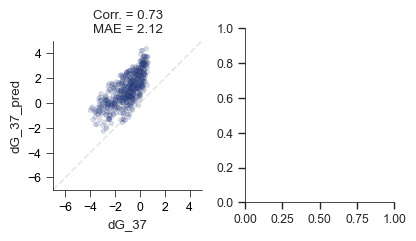

In [7]:
%%time
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

fig, ax = plt.subplots(1, 2, figsize=(4.25, 2.4))
plotkwargs = dict(lim=[-7,5], alpha=.2, color=np.array([57,83,164])/256, linewidth=0.25, edgecolor='k')

# Calculate prediction
val_result_df_nnn = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna-nnn-reg1e-2.json',)
# val_result_df_nupack = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna04.json',)

# Plotting
modeling.plot_validation_result(val_result_df_nnn, param='dG_37', ax=ax[0], **plotkwargs)
modeling.plot_validation_result(val_result_df_nupack, param='dG_37', ax=ax[1], **plotkwargs)

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(2))
    a.tick_params(colors='k', width=.5)
    
# util.save_fig('./fig/Fig4/Validation/dna-nnn-1step_array_test_set_mismatches.pdf')

#### Predict all and plot by category

In [308]:
hairpinloop_ind = [x for x in data_split_dict['test_ind'] if x in arr_adj.index]

val_df = arr_adj.loc[hairpinloop_ind,:]
print(len(val_df))

1446


CPU times: user 810 ms, sys: 161 ms, total: 971 ms
Wall time: 370 ms


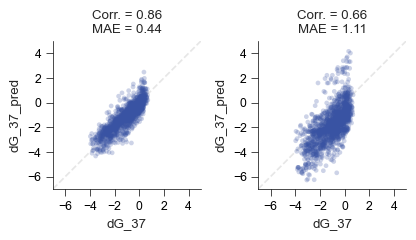

In [315]:
%%time
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

fig, ax = plt.subplots(1, 2, figsize=(4.25, 2.4))
plotkwargs = dict(lim=[-7,5], alpha=.25, color=np.array([57,83,164])/256, linewidth=0)

# Calculate prediction
# val_result_df_nnn = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna-nnn-1step.json',)
# val_result_df_nupack = modeling.make_model_validation_df(val_df, 
#                                   model='nupack', model_param_file='./models/dna04.json',)

# Plotting
modeling.plot_validation_result(val_result_df_nnn, param='dG_37', ax=ax[0], **plotkwargs)
modeling.plot_validation_result(val_result_df_nupack, param='dG_37', ax=ax[1], **plotkwargs)

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(2))
    a.tick_params(colors='k', width=.5)
    
util.save_fig('./fig/Fig4/Validation/dna-nnn-1step_array_test_set_mismatches.pdf')
val_result_df_nnn.to_csv('./data/models/out/val_result_df_dna-nnn-1step_array_test_set.csv')
val_result_df_nnn.to_csv('./data/models/out/val_result_df_dna04_array_test_set.csv')

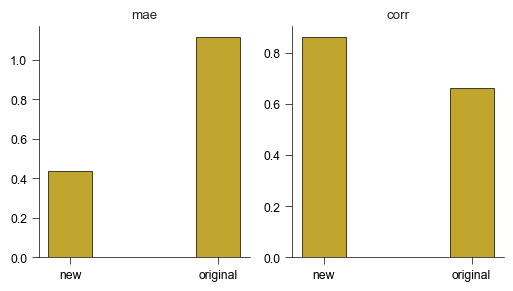

In [382]:
metric_dict = dict()
metric_dict['new'] = modeling.get_metric_dict(val_result_df_nnn, 'dG_37')
metric_dict['original'] = modeling.get_metric_dict(val_result_df_nupack, 'dG_37')
fig, ax = plt.subplots(1,2, figsize=(6,3))
modeling.plot_metric_bar(metric_dict, metric_name='mae', ax=ax[0])
modeling.plot_metric_bar(metric_dict, metric_name='corr', ax=ax[1])

util.save_fig('./fig/Fig4/Test/array_all_test_nupack.pdf')

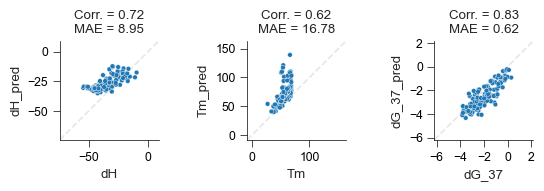

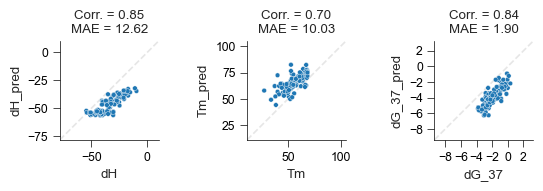

In [390]:
metric_dict['new'] = dict(new=metric_dict['new'])
metric_dict['original'] = dict(new=metric_dict['original'])

for key,v_df in dict(new=val_result_df_nnn, original=val_result_df_nupack).items():
    v_df = v_df.join(annotation['Series'])
    series_list = np.unique(v_df['Series'])
    
    for s in series_list:
        v_df_part = v_df.query('Series == "%s"' % s)
        if s == 'WatsonCrick':
            modeling.plot_validation_result_all_params(v_df_part)
        if len(v_df_part) > 10:
            metric_dict[key][s] = modeling.get_metric_dict(v_df_part, 'dG_37')

In [386]:
df = pd.concat((pd.DataFrame(metric_dict['new']), pd.DataFrame(metric_dict['original']))).rename(columns={'new': 'All'})
df['parameter set'] = ['new', 'new', 'original', 'original']
df = df.reset_index(names='metric')
df = df.melt(id_vars=['metric', 'parameter set'])

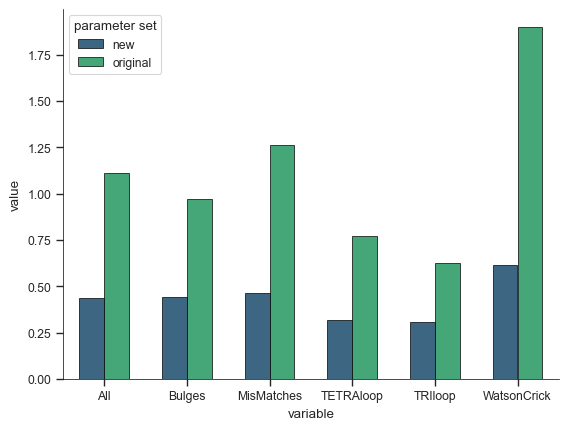

In [391]:
sns.barplot(data=df.query('metric == "mae"'), x='variable', y='value', hue='parameter set',
            palette='viridis', width=.6, edgecolor='k', linewidth=.5)
sns.despine()
util.save_fig('./fig/Fig4/Test/MAE_by_series.pdf')

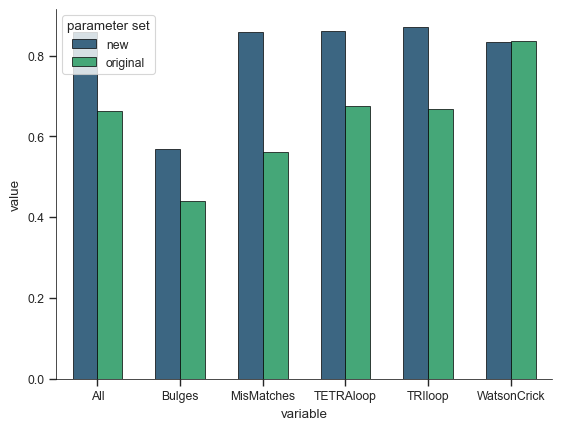

In [388]:
sns.barplot(data=df.query('metric == "corr"'), x='variable', y='value', hue='parameter set',
            palette='viridis', width=.6, edgecolor='k', linewidth=.5)
sns.despine()

### On UV melt data

#### A version freshly made

In [36]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
result_agg_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')
result_agg_df = result_agg_df[result_agg_df.index.isin(hplc_clean_seqid)]
uv_agg_df = result_agg_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean).join(annotation[['RefSeq', 'TargetStruct']])



for i,row in uv_agg_df.iterrows():
    if not isinstance(row.RefSeq, str):
        uv_agg_df.loc[i,'RefSeq'] = ecl_oligo_df.loc[row.name, 'sequence']
        oligo_len = len(ecl_oligo_df.loc[row.name, 'sequence'])
        stem_len = int((oligo_len - 4) / 2)
        target_struct = '('* stem_len + '....' + ')'* stem_len
        uv_agg_df.loc[i,'TargetStruct'] = target_struct

# val_df = uv_agg_df.copy()
# hairpinloop_ind = [x for x in uv_agg_df.index if ((x.startswith('HP')))]
hairpinloop_ind = [x for x in uv_agg_df.index]
val_df = uv_agg_df.loc[hairpinloop_ind]
val_df = val_df.rename(columns=lambda x: x.replace('_uv', ''))

In [38]:
val_df.to_csv('./data/models/raw/uv.csv')

In [22]:
%%time
val_result_df_uv_new = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna-nnn-1step.json',)
metric_dict['uv_new'] = modeling.get_metric_dict(val_result_df_uv_new, 'dG_37')
modeling.plot_validation_result_all_params(val_result_df_uv_new)

NameError: name 'metric_dict' is not defined

CPU times: user 1 s, sys: 51.3 ms, total: 1.06 s
Wall time: 818 ms


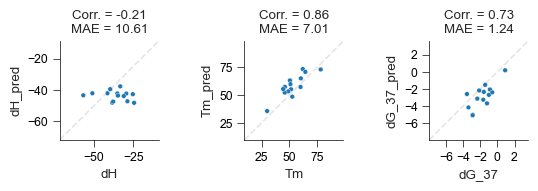

In [322]:
%%time
val_result_df_uv_original = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna04.json',)
metric_dict['uv_original'] = modeling.get_metric_dict(val_result_df_uv_original, 'dG_37')
modeling.plot_validation_result_all_params(val_result_df_uv_original)

In [325]:
pd.DataFrame(metric_dict).to_clipboard()

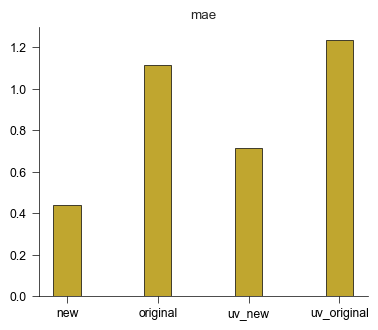

In [323]:
# modeling.plot_metric_bar(metric_dict)
# plt.show()
modeling.plot_metric_bar(metric_dict, metric_name='mae')
util.save_fig('./fig/Fig4/Validation/dna-nnn-1step_array_test_set_and_uv.pdf')

In [213]:
val_df_1 = val_df.copy()

### On Oliveira etc dataset

In [61]:
center_df = fileio.read_Oliveira_df('./data/literature/Oliveira_2020_mismatches.csv')
val_df = center_df.copy()

In [9]:
val_df = center_df.copy()
val_result_df_nupack = modeling.make_model_validation_df(val_df, sodium=0.0675,
                                  model='nupack', model_param_file='./models/dna04.json',
                                  model_kwargs=dict(DNA_conc=1e-6))

val_result_df_nupack['n_mm'] = val_result_df_nupack.TargetStruct.apply(lambda x: int(x.count('.') / 2))

KeyboardInterrupt: 

In [588]:
val_result_df_nupack.to_csv('./data/models/out/Oliveira_val_result_df_dna04.csv')

In [60]:
val_result_df_nupack = pd.read_csv('./data/models/out/Oliveira_val_result_df_dna04.csv', index_col=0)

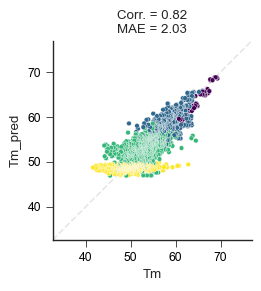

In [61]:
fig, ax = plt.subplots(figsize=(3,3))
modeling.plot_validation_result(val_result_df_nupack, 'Tm', ax=ax, hue='n_mm', palette='viridis', alpha=1)
util.beutify(ax, x_locator=10, y_locator=10)
util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_by_n_mm.pdf')

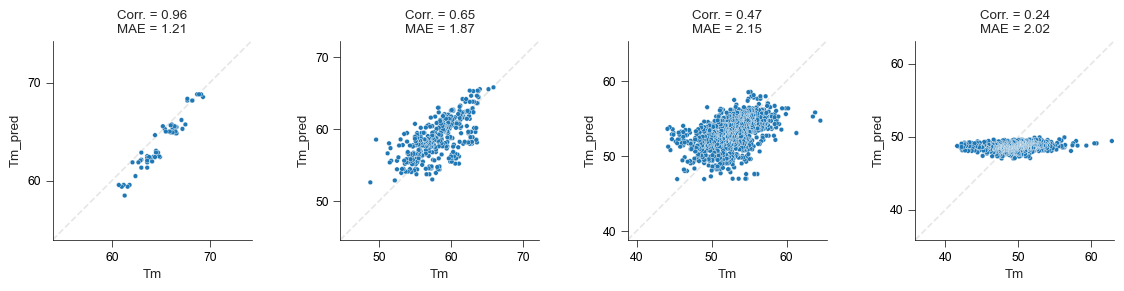

In [586]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
for n in range(4):
    modeling.plot_validation_result(val_result_df_nupack.query('n_mm == %d'%n), 'Tm', ax=ax[n], 
                                    lim=None)
    util.beutify(ax[n], x_locator=10, y_locator=10)

util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_split_by_n_mm_centered.pdf')

In [62]:
val_result_df_nnn = modeling.make_model_validation_df(val_df.iloc[:25,], sodium=0.0675,
                                  model='nupack', model_param_file='./models/dna-nnn-reg1e-1.json',
                                  model_kwargs=dict(DNA_conc=1e-6))

val_result_df_nnn['n_mm'] = val_result_df_nnn.TargetStruct.apply(lambda x: int(x.count('.') / 2))

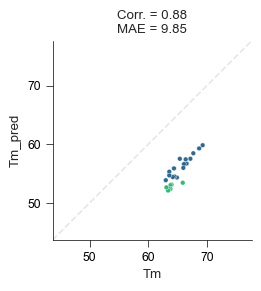

In [63]:
fig, ax = plt.subplots(figsize=(3,3))
modeling.plot_validation_result(val_result_df_nnn, 'Tm', ax=ax, hue='n_mm', palette='viridis')
util.beutify(ax, x_locator=10, y_locator=10)
# util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_by_n_mm.pdf')

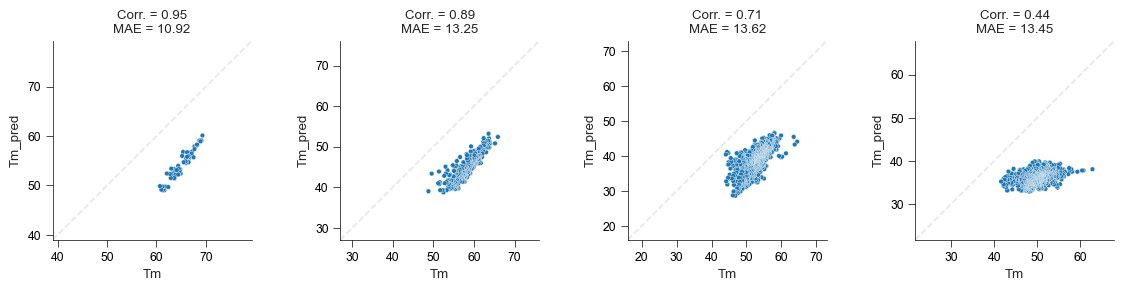

In [591]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
for n in range(4):
    modeling.plot_validation_result(val_result_df_nnn.query('n_mm == %d'%n), 'Tm', ax=ax[n], 
                                    lim=None)
    util.beutify(ax[n], x_locator=10, y_locator=10)

# util.save_fig('./fig/Fig4/Oliveira/NUPACK_Tm_scatter_split_by_n_mm_centered.pdf')

# Parameter visualization

In [26]:
param_set_template_file = './models/dna04.json'
param_json_file = './models/dna-nnn-reg1e-1.json'

In [27]:
p_old_dict = fileio.read_json(param_set_template_file)
p_new_dict = fileio.read_json(param_json_file)

## Hairpin mismatch

In [8]:
key = 'interior_1_1'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index()

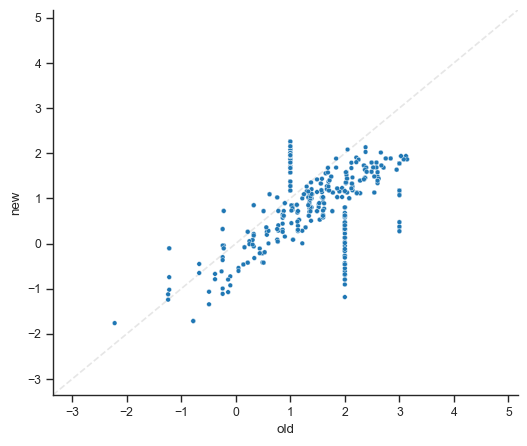

In [9]:
plotting.plot_colored_scatter_comparison(data=df, x='old', y='new', color_by_density=False)

In [10]:
def get_loop(seq, loop_size=4):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size: stem_size+loop_size]

def get_closing_stack(seq, loop_size=4, closing_stack_size=1):
    stem_size = int((len(seq) - loop_size) / 2)
    if stem_size == 1:
        return seq[0] + seq[-1] # avoid problem with indexing at the end
    else:
        return seq[stem_size - closing_stack_size : stem_size] + seq[-stem_size : -stem_size + closing_stack_size]

### Note that closing pair and loop are swapped when it's hairpin mismatch because of the different order NUPACK writes the sequence
loop_size = 4
df['loop'] = df.RefSeq.apply(lambda seq: get_loop(seq, loop_size=loop_size))
df['closing_stack'] = df.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=loop_size, closing_stack_size=1))
df.sort_values(by='loop', inplace=True)
df['loop_out'] = df.apply(lambda x: x.loop[0]+x.loop[-1]+'/'+x.closing_stack, axis=1)
df['loop_center'] = df['loop'].apply(lambda x: x[1:3])
# df = df[df.loop.apply(lambda x: not x in ['AT','TA','CG','GC'])]

In [94]:
df = df[df.closing_stack.apply(lambda x: x in ['AT','TA','CG','GC'])]

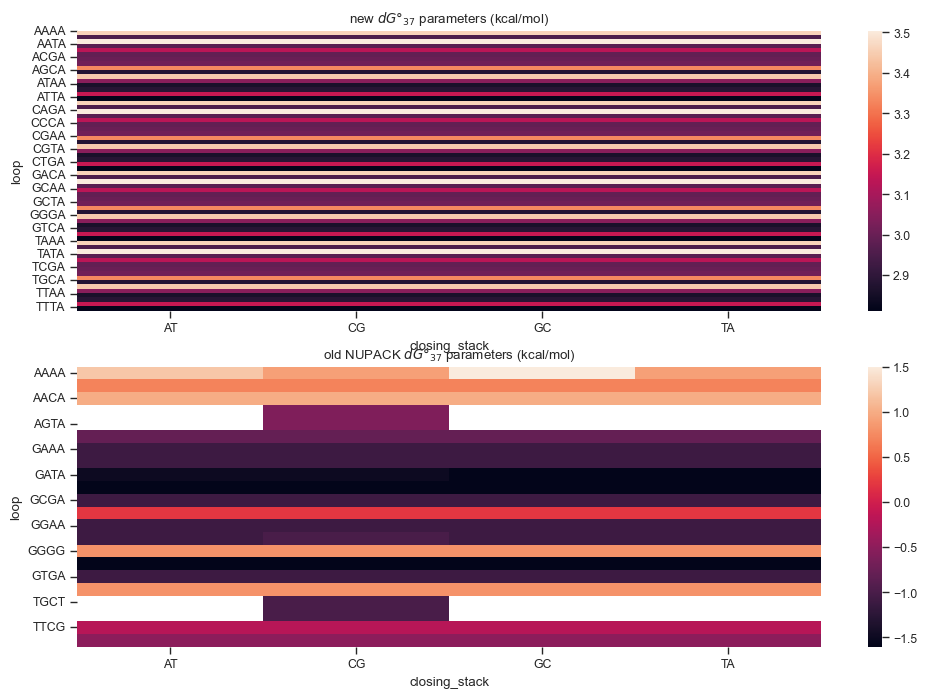

In [95]:
offset = np.nanmean((df.pivot_table(index='closing_stack', columns='loop', values='new') - df.pivot_table(index='closing_stack', columns='loop', values='old')).values)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=False)
# args = dict(vmin=-1.2, vmax=0.2, cmap='cividis', square=False)
args=dict()
sns.heatmap(df.pivot_table(index='closing_stack', columns='loop', values='new').T, ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(df.pivot_table(index='closing_stack', columns='loop', values='old').T, ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')
# for a in ax:
#     a.set_xticks([])
#     a.set_yticks([])
util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_hairpin_mismatch.pdf')

## Compare interior vs hairpin mismatch parameters

In [89]:
mm_compare_df = pd.DataFrame(data=
             dict(interior_mm_old=p_old_dict['dG']['interior_mismatch'], 
                  interior_mm_new=p_new_dict['dG']['interior_mismatch'],
                  hairpin_mm_old=p_old_dict['dG']['hairpin_mismatch'], 
                  hairpin_mm_new=p_new_dict['dG']['hairpin_mismatch'],
                 )
            )

In [97]:
mm_compare_df = mm_compare_df.query('interior_mm_new != 0')

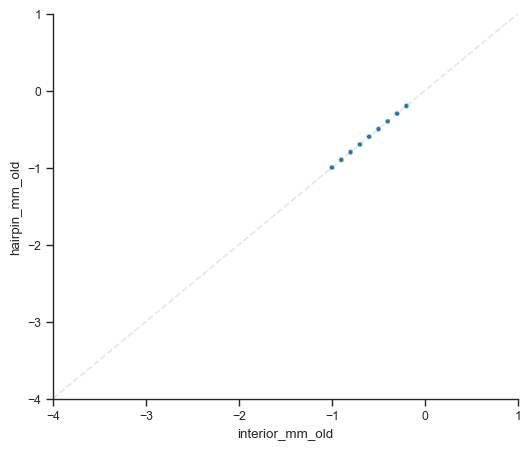

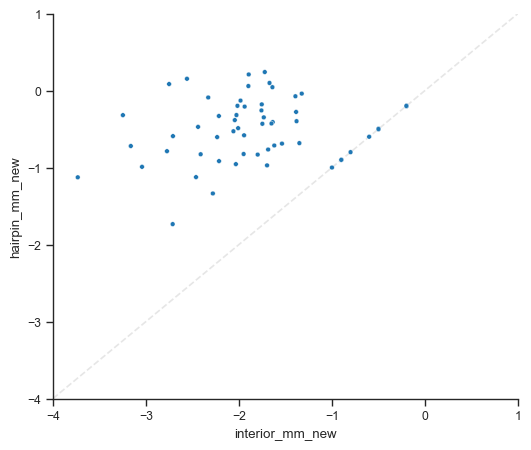

In [99]:
"""
Are all those zeros in interor_mm_new due to underdetermined matrix?
No, they are just WC pairs. LOL. Get rid of them when plotting. 
"""
kwargs = dict(color_by_density=False, lim=(-4,1))
plotting.plot_colored_scatter_comparison(data=mm_compare_df, x='interior_mm_old', y='hairpin_mm_old', **kwargs)

plotting.plot_colored_scatter_comparison(data=mm_compare_df, x='interior_mm_new', y='hairpin_mm_new', **kwargs)

Seems that hairpin mismatches are consistently higher than interior.

## WC [clean]

In [52]:
param_set_template_file = './models/dna04.json'
param_json_file = './models/dna-nnn-reg1e0.json'

p_old_dict = fileio.read_json(param_set_template_file)
p_new_dict = fileio.read_json(param_json_file)

key = 'stack'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

def is_wc_stack(stack):
    return stack[0] == util.rcompliment(stack[-1]) and stack[1] == util.rcompliment(stack[-2])

df = df.loc[df.RefSeq.apply(is_wc_stack)]

# df.new -= np.mean(df.new) - np.mean(df.old)

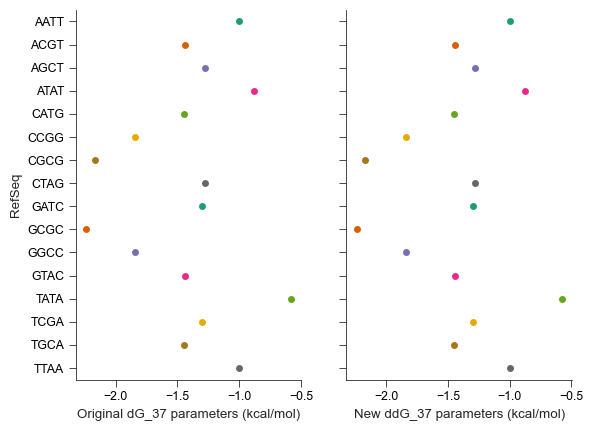

In [53]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
palette = 'Dark2'
sns.stripplot(data=df, orient='h', y='RefSeq', x='old', ax=ax[0], palette=palette)
ax[0].set_xlabel('Original dG_37 parameters (kcal/mol)')
sns.stripplot(data=df, orient='h', y='RefSeq', x='new', ax=ax[1], palette=palette)
ax[1].set_xlabel('New ddG_37 parameters (kcal/mol)')
ax[1].set_ylabel('')
util.beutify_all_ax(ax, x_locator=.5)

# util.save_fig('./fig/Fig4/WC/WC_original_vs_new_dG_37.pdf')

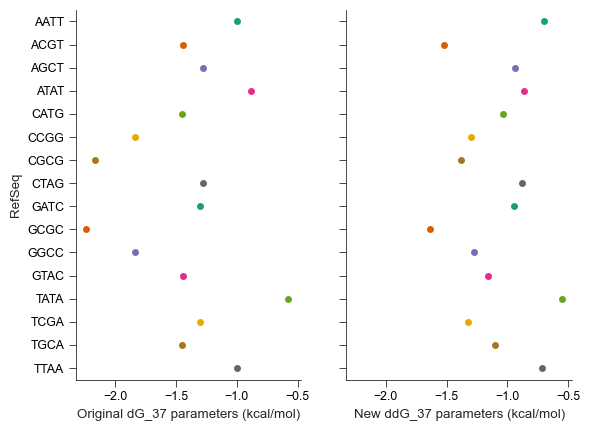

In [18]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
palette = 'Dark2'
sns.stripplot(data=df, orient='h', y='RefSeq', x='old', ax=ax[0], palette=palette)
ax[0].set_xlabel('Original dG_37 parameters (kcal/mol)')
sns.stripplot(data=df, orient='h', y='RefSeq', x='new', ax=ax[1], palette=palette)
ax[1].set_xlabel('New ddG_37 parameters (kcal/mol)')
ax[1].set_ylabel('')
util.beutify_all_ax(ax, x_locator=.5)

util.save_fig('./fig/Fig4/WC/WC_original_vs_new_dG_37.pdf')

## Interior mismatch [clean]

In [102]:
key = 'interior_1_1'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

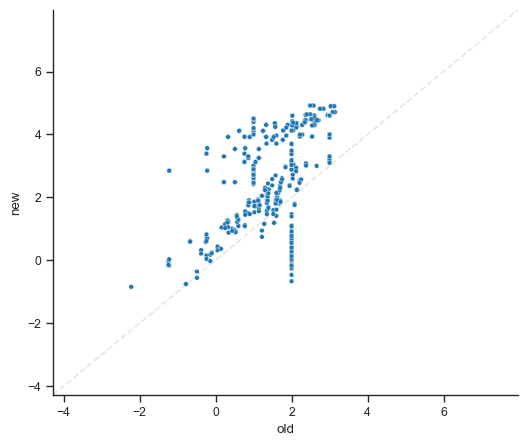

In [103]:
plotting.plot_colored_scatter_comparison(data=df, x='old', y='new', color_by_density=False)

In [121]:
def get_mm(seq):
    if seq[4] != util.rcompliment(seq[1]):
        return f'{seq[1]}·{seq[4]}'
    else:
        return np.nan

def get_context(seq):
    if seq[-1] == util.rcompliment(seq[0]) and seq[3] == util.rcompliment(seq[2]):
        return f'{seq[0]}{seq[-1]}x{seq[2]}{seq[3]}'
    else:
        return np.nan

df['mm'] = df.RefSeq.apply(get_mm)
df['context'] = df.RefSeq.apply(get_context)

df = df.dropna()

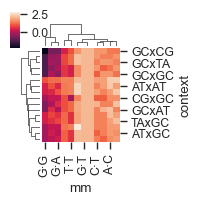

In [170]:
pivot_new = df.pivot_table(index='context', columns='mm', values='new')
pivot_old = df.pivot_table(index='context', columns='mm', values='old')
clustergrid = sns.clustermap(pivot_old, figsize=(2,2))

reordered_index, reordered_columns = util.get_reordered_ind(clustergrid, pivot_new)

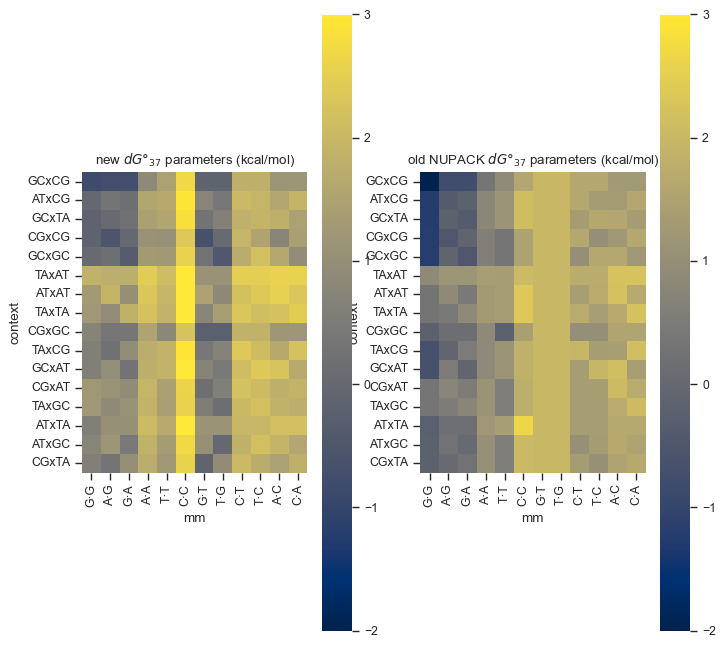

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharex=False)
args = dict(vmin=-2, vmax=3, cmap='cividis', square=True)

sns.heatmap(pivot_new.loc[reordered_index, reordered_columns], ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(pivot_old.loc[reordered_index, reordered_columns], ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')

util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_single_mismatch.pdf')